### VAE with convolutional layers

When moving to more complex image dataset, it's useful to use convolutional layers.

Here we move from the 28x28 MNIST dataset to the 64x64 pixels moving MNIST dataset. We decomposes the videos into a set of images to ahve a simple images dataset. 

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# parameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 50

img_size = 64


cuda


In [25]:
data = np.load('data/bouncing_mnist_test.npy')
data = data.reshape((200000,1,64,64)) # we split the 10000 video of 20 frames into 200000 images of 64x64 pixels
data = data / 255 # normalize pixel value between 0 and 1, like the MNIST dataset

# the data is shuffled when loaded
train_loader = torch.utils.data.DataLoader(
                 dataset=data,
                 batch_size=batch_size,
                 shuffle=True)

In [26]:
class VAE(nn.Module):
    def __init__(self, img_size=img_size, latent_dim=16,nb_output_channel=32,hidden_dim=256):
        super(VAE, self).__init__()

        self.nb_output_channel = nb_output_channel

        # this is a bunch of stupidly harcoded numbers because I never manage to get the dimensions right with convolutional layers
        # I should probably use a library for that
        self.featureDim = (img_size - 8)*(img_size - 8)*self.nb_output_channel
        self.featurePooledDim = self.nb_output_channel*14*14
        self.featurePooledDim_dec = self.nb_output_channel*12*12

        self.hiddenDim = hidden_dim
        self.latentDim = latent_dim

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(1, self.nb_output_channel//2, 5)
        self.encConv2 = nn.Conv2d(self.nb_output_channel//2, self.nb_output_channel, 5)
        # the maxpooling layer is used to reduce the size of the feature map
        self.maxpool = nn.MaxPool2d(4)
        self.encFC = nn.Linear(self.featurePooledDim, self.hiddenDim)

        self.encFC_mean = nn.Linear(self.hiddenDim, self.latentDim)
        self.encFC_var = nn.Linear(self.hiddenDim, self.latentDim)
        
        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC = nn.Linear(self.latentDim, self.hiddenDim)
        self.decFC1 = nn.Linear(self.hiddenDim, self.featurePooledDim_dec)
        self.decConv1 = nn.ConvTranspose2d(self.nb_output_channel, self.nb_output_channel//2, kernel_size=5,stride=5)
        self.decConv2 = nn.ConvTranspose2d(self.nb_output_channel//2, 1, kernel_size=5)
        
    def encoder(self, x):
        
        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = self.maxpool(x)
        x = x.view(-1, self.featurePooledDim)
        x = F.relu(self.encFC(x))
        mu = self.encFC_mean(x)
        logVar = self.encFC_var(x)
        return mu, logVar
    
    def reparameterize(self, mu, logVar):
        
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decoder(self, z):
        
        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC(z))
        x = F.relu(self.decFC1(x))
        x = x.view(-1, self.nb_output_channel, 12, 12)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x
        
    def forward(self, x):
        
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [27]:
net = VAE().to(device)
print('nb of params : {}'.format(count_parameters(net)))

nb of params : 2829185


In [28]:
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [37]:
from tqdm import tqdm

for epoch in range(num_epochs):

    pbar = tqdm(train_loader)
    pbar.set_description("epoch %s/ loss=? " % str(epoch+1))
    
    for data in pbar:
        
        imgs = data
        imgs = imgs.to(device).float()
        
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)
        
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description("epoch "+str(epoch+1)+"/"+str(num_epochs)+"/ loss= "+str(loss.cpu().detach().numpy()) )
        
        

epoch 20/20/ loss= 38438.3:  22%|██▏       | 341/1563 [00:02<00:09, 122.91it/s]  

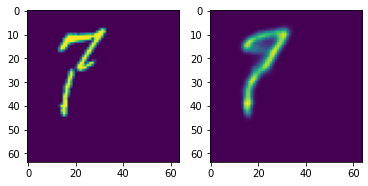

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for data in random.sample(list(train_loader), 1):
        imgs = data
        imgs = imgs.to(device).float()
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))

In [31]:
# saving a model
torch.save(net.state_dict(), 'model/vae_moving_digits.pt')

In [32]:
# loading a model
net = VAE().to(device)
net.load_state_dict(torch.load('model/vae_moving_digits.pt'))
net.eval()

VAE(
  (encConv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (encConv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (encFC): Linear(in_features=6272, out_features=256, bias=True)
  (encFC_mean): Linear(in_features=256, out_features=16, bias=True)
  (encFC_var): Linear(in_features=256, out_features=16, bias=True)
  (decFC): Linear(in_features=16, out_features=256, bias=True)
  (decFC1): Linear(in_features=256, out_features=4608, bias=True)
  (decConv1): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(5, 5))
  (decConv2): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1))
)

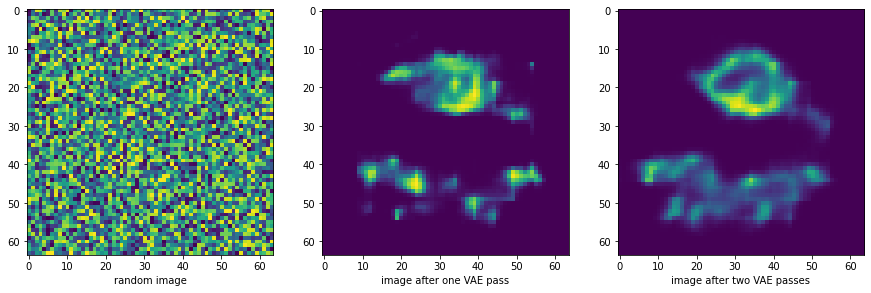

sigma after one pass : [[ -7.404961   -9.135054   -9.243659   -9.504133   -9.27522    -6.279163
   -6.724905   -8.639657  -10.154284  -10.514072   -9.491285   -7.305306
   -6.9862475  -7.3980556  -7.747734   -7.6692758]]
sigma after two passes : [[-5.333266  -6.8530226 -6.877215  -6.3087378 -6.3635516 -4.4817567
  -4.290949  -5.944028  -7.325508  -7.3074117 -6.6428156 -4.7834134
  -4.6636605 -4.7449775 -5.324432  -4.84579  ]]


In [33]:
rd_img = np.random.uniform(size=(img_size,img_size)).astype(np.float32)

reconstruct_rd_img,_,r_sigma = net(torch.tensor([[rd_img]]).to(device))
reconstruct_rd_img = reconstruct_rd_img.detach().cpu().numpy()[0,0]

reconstruct_reconstruct_rd_img,_,r_r_sigma = net(torch.tensor([[reconstruct_rd_img]]).to(device))
reconstruct_reconstruct_rd_img = reconstruct_reconstruct_rd_img.detach().cpu().numpy()[0,0]

f = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rd_img)
plt.xlabel('random image')

plt.subplot(1,3,2)
plt.imshow(reconstruct_rd_img)
plt.xlabel('image after one VAE pass')

plt.subplot(1,3,3)
plt.imshow(reconstruct_reconstruct_rd_img)
plt.xlabel('image after two VAE passes')

plt.show()

print('sigma after one pass : {}'.format(r_sigma.detach().cpu().numpy()))
print('sigma after two passes : {}'.format(r_r_sigma.detach().cpu().numpy()))